TODO: 
* Good copy of the embedding chart, include highlighting for each step
* Change names of embeddings to be consistent in the code parts wrt the prose parts
* Add functions to clean up long viz cells
* Reorganize: Wasserstein before Approximate Wasserstein
* Move getting word vectors to the Wasserstein steps?

# Comparing Document Embeddings

The goal of this notebook is to use the tools in the [Tutte Institute ``vectorizers`` library](https://github.com/TutteInstitute/vectorizers) to construct document embeddings, and to compare those document embeddings with results from other popular techniques. We will compare embeddings obtained by the following techniques:
* Universal Sentence Encoder (USE) from Google
* Bidirectional Encoder Representations from Transformers (BERT) from Google
* TF-IDF (sklearn)
* Information Weighted Embedding (vectorizers library)
* Wasserstein Embedding (vectorizers library)
* Approximate Wasserstein Embedding (vectorizers library)

We will compare these techniques qualitatively using the advanced eyeball test (via dimension reduction using UMAP) as well as by quantitatively using a downstream classification task.

At this point ``vectorizers`` is still a research project, so this is not meant to be a rigorous comparison but rather a demonstration of general relative performance, and to show off the potential for non-neural net based approaches.

In [1]:
from src import paths
from src.data import Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings
      
warnings.simplefilter("ignore")
sns.set()

We will need some data to work with. For the purposes of this demo we will make use of the 20 newsgroups dataset. Even though 20 newsgroups is a toy dataset, it offers enough complications to show how we can piece together document embeddings using ``vectorizers``.

In [3]:
ds = Dataset.load('20_newsgroups')

In [10]:
print(ds.DESCR)


The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

Here are the categories:

 * `alt.atheism`,
 * `comp.graphics`,
 * `comp.os.ms-windows.misc`,
 * `comp.sys.ibm.pc.hardware`,
 * `comp.sys.mac.hardware`,
 * `comp.windows.x`,
 * `misc.forsale`,
 * `rec.autos`,
 * `rec.motorcycles`,
 * `rec.sport.baseball`,
 * `rec.sport.hockey`,
 * `sci.crypt`,
 * `sci.electronics`,
 * `sci.med`,
 * `sci.space`,
 * `soc.religion.christian`,
 * `talk.politics.guns`,
 * `talk.politics.mideast`,
 * `talk.politics.misc`,
 * `talk.religion.misc`

The current version is obtained by wrapping `sklearn.datasets.fetch_20newsgroups

First, we will do a little pruning: the 20 newsgroups dataset contains some extremely short posts (once the headers, footers and quotes are removed) that will muddy up the results. We will prune out any post less than 200 characters (200 is chosen somewhat arbitrarily).

In [4]:
long_enough = [len(t) > 200 for t in ds.data]
targets = np.array(ds.target)[long_enough]
news_data = [t for t in ds.data if len(t) > 200]

For each newsgroup post, the target data is the name of the newsgroup the post was sent to. There are broad groups that the specific newsgroups can be classified into, such as religion, politics, computing, sport and science. While some of broad groups can be gleaned programmatically from the newsgroup name (with its dotted hierarchy), some groups (like alt.atheism being in the religion topic) require more care. We will hand curate the newsgroups into 6 broad categories:
* religion
* politics
* sport
* comp
* sci
* misc

Using these broad categories, we will create a custom color palette for the data when visualizing results such that different newsgroups in the same category can have similar colours.

In [5]:
religion = ("alt.atheism", "talk.religion.misc", "soc.religion.christian")
politics = ("talk.politics.misc", "talk.politics.mideast", "talk.politics.guns")
sport = ("rec.sport.baseball", "rec.sport.hockey")
comp = (
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
)
sci = (
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
)
misc = (
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
)

In [6]:
color_key = {}
for l, c in zip(religion, sns.color_palette("Blues", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(politics, sns.color_palette("Purples", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(comp, sns.color_palette("YlOrRd", 5)):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(sci, sns.color_palette("light:teal", 5)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(sport, sns.color_palette("light:#660033", 4)[1:3]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(misc, sns.color_palette("YlGn", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)

With a dataset and a carefully designed color palette we are in good shape to do some qualitative analysis of different document embedding methods using UMAP to obtain visualizations of the embeddings.

# Universal Sentence Encoder

The Universal Sentence Encoder (USE), from Google, makes use of a Deep Averaging Network and supervised training to learn a document embedding. It is simultaneously extremely powerful and opaque. While papers describe USE's overall architecture and broad design choices, the exact details, pre-training corpus, etc. are not easily accessible or clear. However, it does a remarkable job of embedding sentences and short documents in a useful and coherent way. We will use the standard "out of the box" approach and load the model directly from tensorflow_hub.

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

In [12]:
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2021-06-01 10:45:54,348 - resolver - INFO - Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-06-01 10:46:11,433 - resolver - INFO - Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 50.00MB
2021-06-01 10:46:28,221 - resolver - INFO - Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 100.00MB
2021-06-01 10:46:44,885 - resolver - INFO - Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 150.00MB
2021-06-01 10:47:01,772 - resolver - INFO - Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 200.00MB
2021-06-01 10:47:18,801 - resolver - INFO - Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 250.00MB
2021-06-01 10:47:35,615 - resolver - INFO - Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 300.00MB
2021-06-01 10:47:52,371 - resolver - INFO - Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 350.00MB
2021-06-01 10:48:09,283 - resolver

USE is simple to use--we can pass it the raw text and not worry about tokenization or other preprocessing. We get back is a set of vectors, one for each document, that hopefully captures useful information.

In [13]:
%%time
#use_vectors = use_embed(news_data).eval(session=tf.compat.v1.Session())
use_vectors = use_embed(news_data).numpy() # requires Tensorflow 2.0+

CPU times: user 6min 46s, sys: 3min 20s, total: 10min 7s
Wall time: 13min 29s


We now pass the results of USE into UMAP in order to visualize the results, making use of our custom color palette, to see how well USE has managed to represent 20 newsgroups. Ideally we would like to see different newsgroups reasonably well separated, although the data is noisy and several newsgroups have overlapping content, so perfect results are far too much to hope for.

In [14]:
use_mapper = umap.UMAP(metric="cosine", random_state=42).fit(use_vectors)

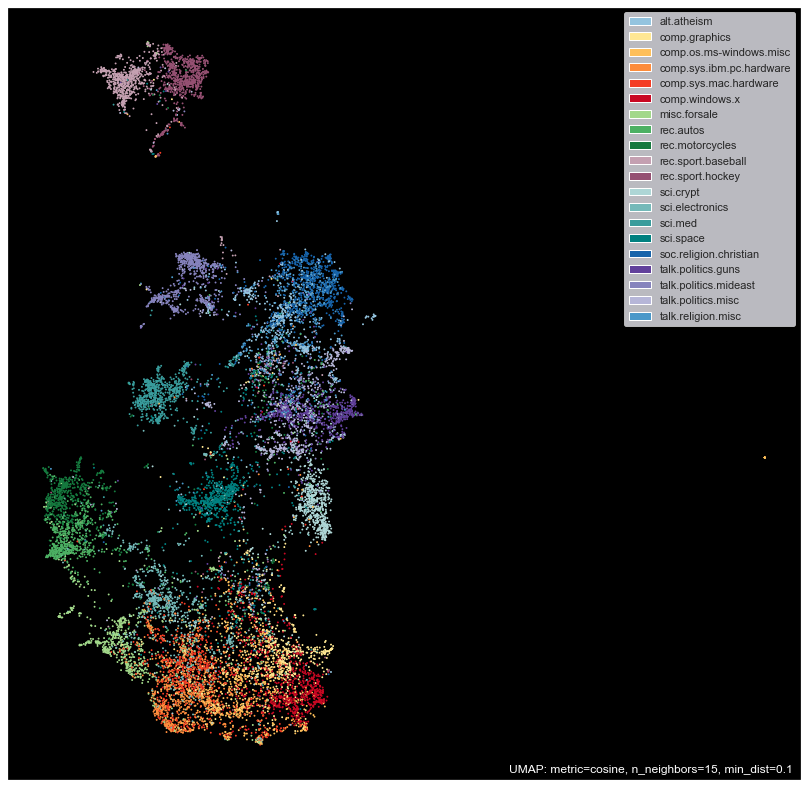

In [16]:
umap.plot.points(
    use_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "universal_sentence_encoder.png", facecolor="none")

The results are impressive -- several of the newsgroups are well separated, and the remainder are, at least, largely grouped with newsgroups of a similar colour, showing that USE is grouping posts on similar topics. There is still a fair amount of noise floating around, but that is to be expected: as already noted the newgroups data is messy.

# BERT Sentence Transformer

Next up is the Bidirectional Encoder Representations from Transformers (BERT), also from Google. BERT uses a pretrained transformer architecture. BERT has been primarily designed for use in downstream task applications with the expectation that users will do fine-tuning training specific to the task. For general use in sentence embedding we turn to the ``sentence_transformers`` library which has used a siamese achitecture to do fine tuning training on the task of sentence similarity. This is not the best way to use BERT for the various tasks we are applying it to here, but it is simple to get up an running and is the most common approach among practitioners for producing sentence embeddings with BERT.

In [17]:
from sentence_transformers import SentenceTransformer

The ``sentence_transformers`` library requires loading a specific BERT model. In this case we'll choose a small basic BERT model, frequently used as a baseline BERT model for sentence embedding tasks.

In [18]:
sent_trans_model = SentenceTransformer("stsb-distilbert-base")

2021-06-01 11:16:12,704 - SentenceTransformer - INFO - Load pretrained SentenceTransformer: stsb-distilbert-base
2021-06-01 11:16:12,721 - SentenceTransformer - INFO - Did not find folder stsb-distilbert-base
2021-06-01 11:16:12,729 - SentenceTransformer - INFO - Search model on server: http://sbert.net/models/stsb-distilbert-base.zip
2021-06-01 11:16:12,732 - SentenceTransformer - INFO - Load SentenceTransformer from folder: /Users/amywooding/.cache/torch/sentence_transformers/sbert.net_models_stsb-distilbert-base
2021-06-01 11:16:14,384 - SentenceTransformer - INFO - Use pytorch device: cpu


Once we have the model loaded (it may take a while to download -- it is a large model) encoding the newsgroup posts is straightforward, only requiring us to use the ``encode`` method. Note that since we are running without a GPU this will take quite a bit longer than it might with better hardware.

In [19]:
%%time
bert_vectors = sent_trans_model.encode(news_data, show_progress_bar=False)

CPU times: user 41min 1s, sys: 2min 7s, total: 43min 9s
Wall time: 43min 6s


As with USE, we can pass the results into UMAP to get an overall qualitative look at how well we are doing at sentence embedding. As before our hope is to see separation of the different newsgroups, and at the very least clean groupings of the broad categories of newsgroups together.

In [20]:
%%time
bert_mapper = umap.UMAP(metric="cosine", random_state=42).fit(bert_vectors)

CPU times: user 18.3 s, sys: 1.33 s, total: 19.6 s
Wall time: 16.6 s


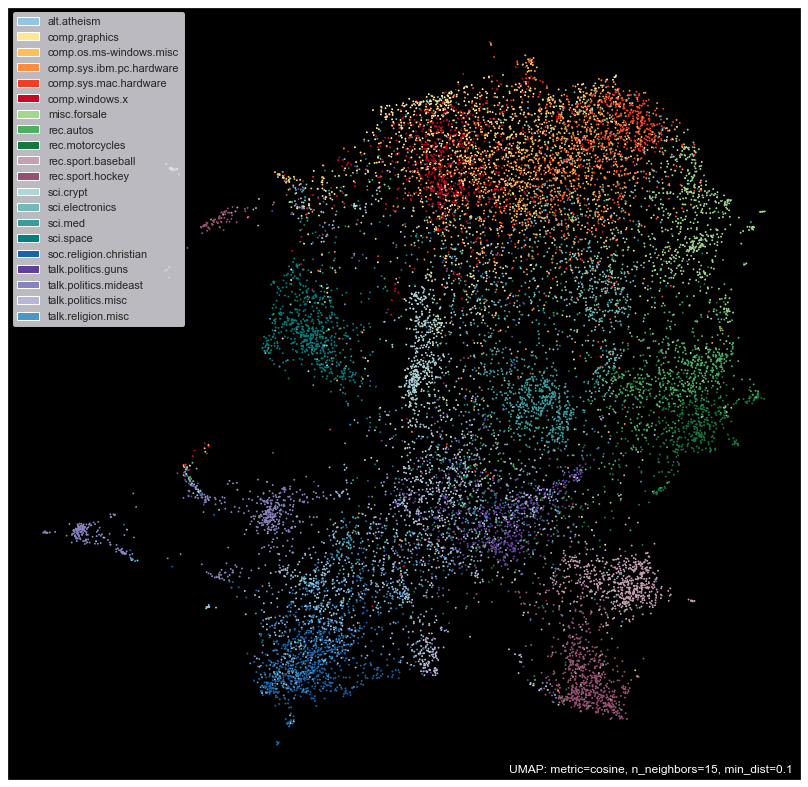

In [21]:
umap.plot.points(
    bert_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "bert.png", facecolor="none")

The results from BERT are a little underwhelming given the general view that BERT is the state-of-the-art for NLP tasks. To be fair to BERT, this is not how it is meant to be used by the original developers as we haven't done custom fine-tuning. On the other had, this *is* how BERT often gets used for sentence embedding in practice (possibly because this approach is so easy to use). It will suffice as a representative example of basic BERT embeddings as used in practice.

# Vectorizers library

Having looked at USE and BERT let's turn our attention to what we can get done with simple transformations without using pre-trained neural networks. For this I'll be using the [``vectorizers`` library from the Tutte Institute](https://github.com/TutteInstitute/vectorizers). This library provides most of the building blocks we need to build a variety of different document embeddings.

The first thing to note is that the ``vectorizers`` library is not specifically built for embedding text -- instead the library is designed to cope with generic types of data. The part of the library we'll be using is designed to deal generically with sequences of tokens -- this could be tokenized text, sequences of network packet types, sequences of malware behaviours, or anything that can be viewed of sequences of categorical values. This makes the tools in ``vectorizers`` more general, and applicable to many domains beyond text and NLP, but it also means we'll need text specific tools to convert our text into sequences of tokens.

We will create embeddings via the following steps and combinations:
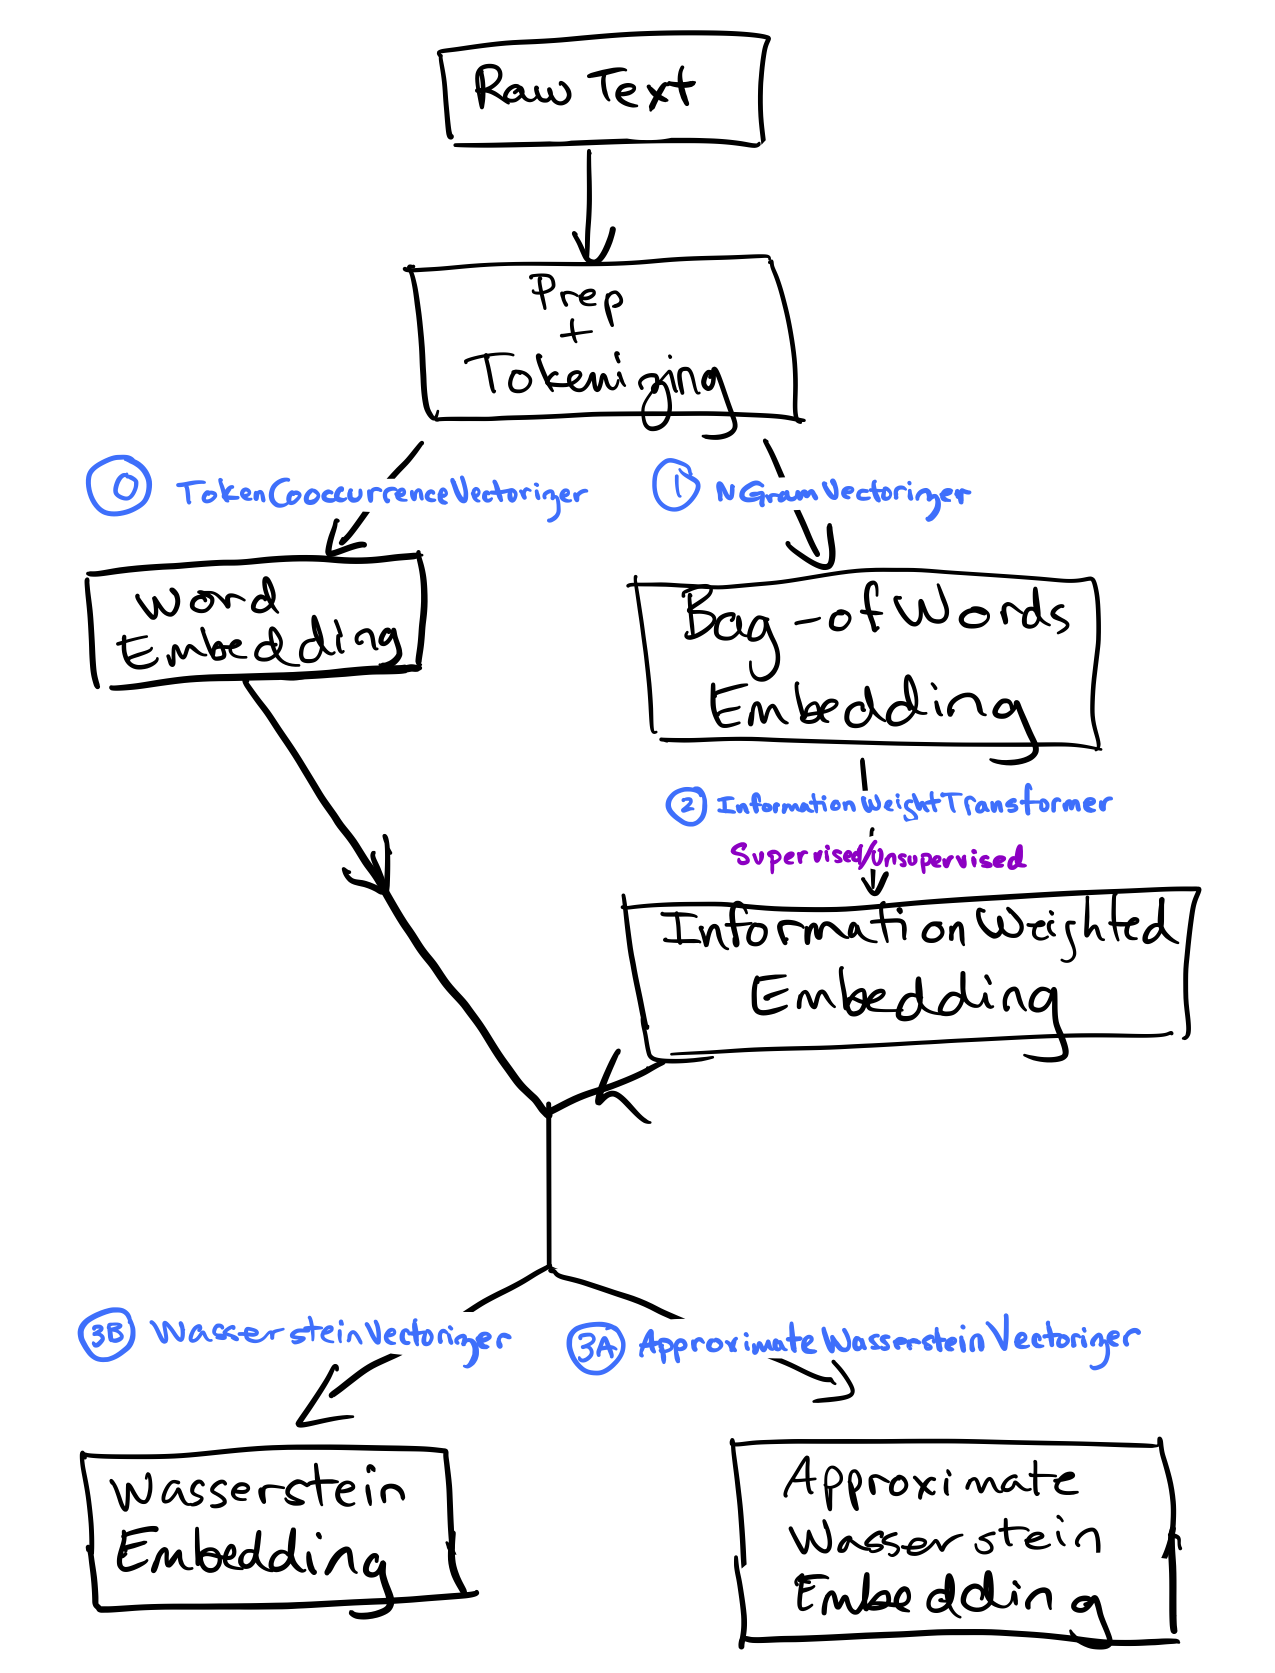

To help clarify what is going on, we'll step through the process slowly and show the different branching off points. This means that the process of building the document embeddings will involve more steps than with the APIs provided by BERT and USE. However, it would not be hard to glue the pieces together into sklearn pipelines or similar to get a BERT or USE style API. Many of the steps build on each other.

For these examples, we'll use the preprocessor and tokenizer built into sklearn's ``CountVectorizer``. We will start by converting the text into sequences of tokens (i.e. lists of hashable objects, in this case lists of words as strings).

In [22]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True)
sk_word_tokenize = cv.build_tokenizer()
sk_preprocesser = cv.build_preprocessor()
tokenize = lambda doc: sk_word_tokenize(sk_preprocesser(doc))
tokenized_news = [tokenize(doc) for doc in news_data]

CPU times: user 1.49 s, sys: 107 ms, total: 1.59 s
Wall time: 1.7 s


### Step 0: Word Embedding

The first thing we'll do is learn a richer representation of the tokens by learning word vectors for the words that appear in our corpus. Classic algorithms like word2vec and GloVe could work for this, but since we are trying to keep things basic we'll use the the ``TokenCooccurrenceVectorizer`` from the vectorizers library. This is a  tool that counts token cooccurrences in windows within a set of token sequences. In other words, it creates a vocabulary by vocabulary sparse matrix where an entry counts how often two tokens cooccurred within some range of each other in the entire set of sequences. This is what is going on at the heart of algorithms like word2vec and GloVe.

The ``TokenCooccurrenceVectorizer`` makes this direct counting approach available for *generic* token sequences in addition to text, and provides flexibility and options as to how windows are constructed, weighted, and so on.

#### Setting parameters for ``TokenCooccurrenceVectorizer``
Since we don't have a lot of text in the 20 newsgroups dataset, we won't use any of the advanced functionality.

We'll restrict to tokens that occur in at least 5 documents (pruning out rare words that won't likely be useful or informative). We'll use a window radius of twenty words, with variable windowing sizes around that based upon word frequency. We'll also make use of a "geometric" kernel over the window, giving less weight (in a geometric progression) to words further away in the window.

The ``TokenCooccurrenceVectorizer`` also supports the use of an iterative expectation-maximization algorithm to refine the kernel weighting of words within windows, but with so little data this will not be worthwhile (so we set ``n_iters=0``). Finally it is worth noting that by default ``TokenCooccurrenceVectorizer`` uses directional windowing, keeping track of occurrences before, and after, a given word separately. We will leave this in place, as it is beneficial.

Once the cooccurrences counted, it remains to convert the sparse matrix into dense word vectors. Conveniently this is coded up as the ``reduce_dimension`` method in the ``TokenCooccurrenceVectorizer``. The ``reduce_dimension`` method:
1. normalizes columns,
2. normalizes rows, 
3. applies a transform on to make euclidean distance in the transformed space a better approximation to Hellinger distance in the original space, and 
4. applies a standard SVD to get dense vectors. 

In [23]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=20,          
    window_functions='variable',
    kernel_functions='geometric',            
    n_iter = 0,
    normalize_windows=True,
).fit(tokenized_news)
word_vectors = word_vectorizer.reduce_dimension(dimension=160, algorithm="randomized")

CPU times: user 3min 36s, sys: 11.1 s, total: 3min 47s
Wall time: 4min


These operations are relatively quick because it is matter of counting things and applying standard linear algebra techniques. This produces serviceable word vectors which are specifically trained on our corpus and cover the idiomatic usage of various words within the particular context of the 20 newsgroups dataset.

### Step 1: Bag-of-words Embedding

The next step in the process is to get a document embedding, that is, obtain document vectors. Since we will be using the word vectors that we've learned later, we will restrict our document embedding to the same vocabulary as the word vectors. 

To start with let's create a bag-of-words model. For that, we'll use the ``NgramVectorizer`` which is the vectorizer libraries "sequence of tokens" counterpart to the text specific ``CountVectorizer`` from sklearn.


In [24]:
%%time
doc_matrix = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
).fit_transform(tokenized_news)

CPU times: user 13.6 s, sys: 257 ms, total: 13.9 s
Wall time: 14.5 s


Since bag-of-words is basically counting, this is very fast. The next step will be to visualize what we have so far (keeping in mind that this is the raw initial representation). We can use UMAP for this as we did with USE and BERT.

In [25]:
%%time
raw_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(doc_matrix)

CPU times: user 4min 23s, sys: 2.27 s, total: 4min 25s
Wall time: 1min 50s


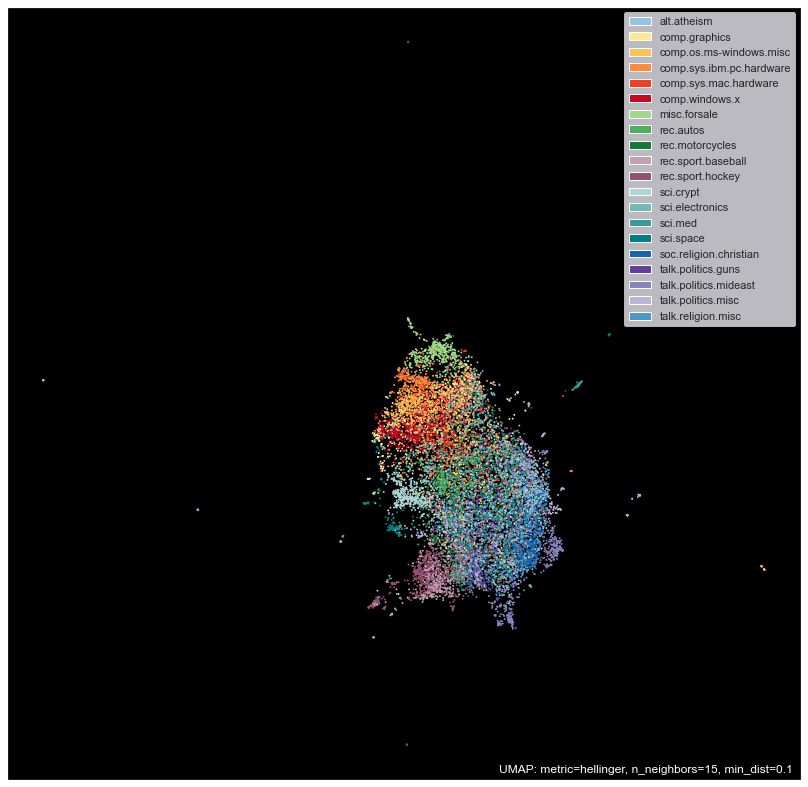

In [26]:
umap.plot.points(
    raw_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "doc_count_embedding.png", facecolor="none")

Not a great result! We can see why USE and BERT are popular compared to a pure bag-of-words approach. Still this is just the starting point for our document embedding, there are more steps to go.

### Step 2: Information Weight Embedding

Not all words are equally informative. For example, "the" and "embedding" contain different amounts of information in a sentence. Since each feature column of our bag-of-words representation corresponds to a word, we would like to have some feature weighting scheme that can account for the different amounts of information coming from each word.

This is behind the thinking of the classic TF-IDF approach, words are weighted according to the (log of the) inverse frequency of document occurrences of the word. While this can be effective it is a little ad-hoc. We will make this approach more explicit using of the ``InformationWeightTransformer`` from ``vectorizers``.

The ``InformationWeightTransformer`` takes an information theoretic view to generating feature weights for count data. To determine a weight for how "informative" a word is, we look at the amount of information gained by using the actual observed distribution of occurrences of the word among documents instead of a baseline distribution (the distribution of occurrences assuming the word occurred uniformly randomly in the text). We can enhance this a by making use of a Bayesian prior on the distribution (ensuring that infrequent words aren't artificially deemed to be informative).

The ``InformationWeightTransformer`` can go a step further however. Instead of looking at information gain from distributions over documents, we can also factor in information gain from distributions over *labels* if we happen to have label information. In this case we do have label information, but in many cases we may not.

To show the full range of options we'll take both approaches--an unsupervised approach which does not see any label information, and the supervised approach where we can take advantage of distributions over labels to determine feature weights.

In [27]:
%%time
unsupervised_info_doc_matrix = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(doc_matrix)

supervised_info_doc_matrix = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(doc_matrix, targets)

CPU times: user 6.26 s, sys: 109 ms, total: 6.37 s
Wall time: 6.91 s


This is a remarkably efficient process! To see the impact of re-weighting the features on our document embedding, we'll use UMAP again.

In [28]:
%%time
unsupervised_info_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(unsupervised_info_doc_matrix)
supervised_info_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(supervised_info_doc_matrix)

CPU times: user 5min 18s, sys: 2.06 s, total: 5min 20s
Wall time: 2min 1s


First let's look at the unsupervised case, achieved only by looking at distributions over documents and with no label information whatsoever.

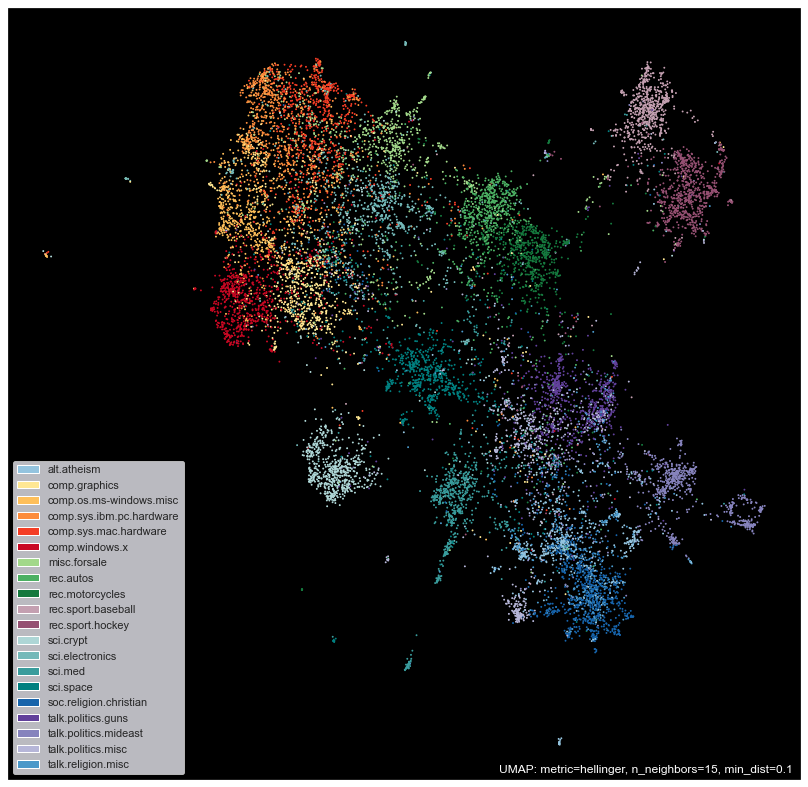

In [29]:
umap.plot.points(
    unsupervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "info_weight_unsupervised.png", facecolor="none")

This looks like a huge improvement over the raw bag-of-words approach and all we have done is reweight the columns. From a visual inspection this looks at least somewhat comparable to the BERT embedding. That is pretty impressive for such a simple and cheap transformation of the bag-of-words document model.

Let's see what can be achieved with the additional use of label information in deciding how to reweight columns. Keep in mind that we are not tagging rows with label information, we are scaling columns by the amount of information we deem each column to have. The label information is allowing us to upweight columns that appear to be "informative" with respect to labels.

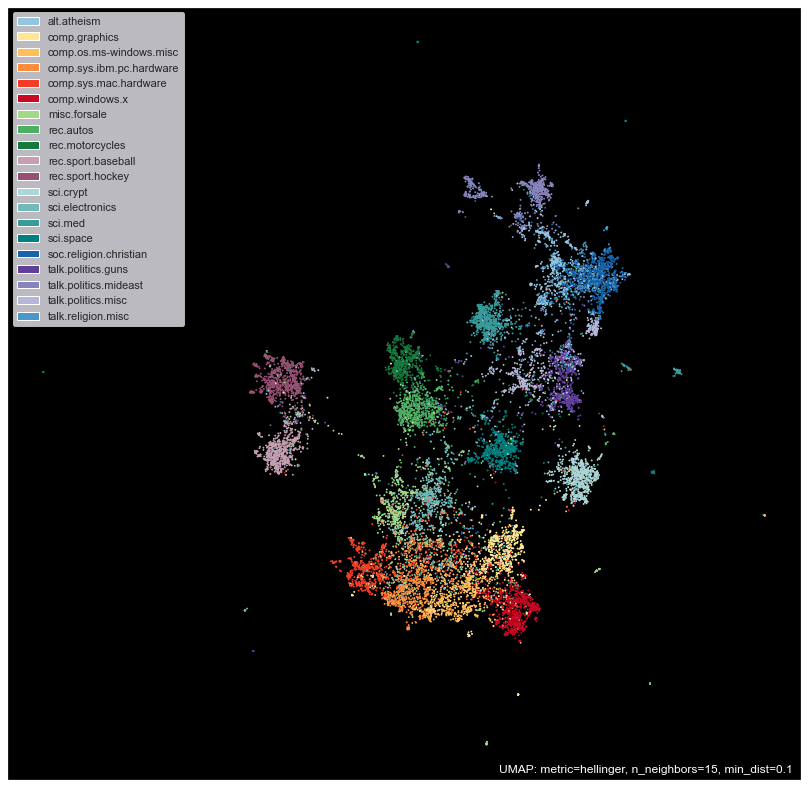

In [30]:
umap.plot.points(
    supervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "info_weight_supervised.png", facecolor="none")

This is remarkably good! Yes, we made use of label information, but it is not that uncommon to have such some labels on hand. Notably, since we only used that information to derive feature weights, we can easily use this transformer on a training set and apply the learned weights to an unlabeled test set. 

### Step 3A: Wasserstein Embedding via Linear Algebra Approximation

It's time to start applying more sophisticated transformations. We will use the ``ApproximateWassersteinVectorizer`` which applies basic linear algebra transformations to provide heuristic approximations to a linearization of a Wasserstein metric space. Okay, that was a mouthful; let's unpack this in terms of document representation and word vectors.

The output from the Information Weighted document embedding are vectors of (weighted) counts of how often each word appears in each document. When we applied UMAP to this embedding, we used Hellinger distance where we view these vectors as defining (multinomial) distributions over our feature space of words.

This is all very well, but words are not completely independent of each other (which a multinomial distribution would assume). Some words are similar; other words are completely unrelated. In other words we have a metric space of words. And indeed we already have a metric space of words as defined by our word vectors as long as we have a suitable distance function.

Since our word vectors are computed as distributions, measuring the distance between these word vectors requires measuring distances between distributions. So then, how do we measure distances between distributions over metric spaces? Not Hellinger distance anymore, but Wasserstein distance. Unfortunately Wasserstein distance is exceedingly expensive to compute; in this case it is effectively the same as [Word Mover Distance](http://proceedings.mlr.press/v37/kusnerb15.pdf) with our custom feature weighting. We can plug Wasserstein distance into UMAP and get a 2D embedding, but it will take a hours and hours to compute.

To take a different approach, what if we could transform our data so that cosine distance in the transformed space was closely correlated with Wasserstein distance in the original space? Then applying UMAP with cosine distance on the transformed space would approximate UMAP with Wasserstein distance on the original space. 

Let's begin by trying quick and dirty transformations that only require simple linear algebra operations to do this. We will compare this to a theoretically sound approach in the next example.

We will apply basis transformations and rescalings to combine the word vectors with the document representations. The result will be document vectors with the same dimensionality as our word vectors that heuristically provide an approximation to the theory-based approaches we'll be trying next. 

The `vectorizers` library provides this functionality in the ``ApproximateWassersteinVectorizer`` which takes as input a sparse matrix where each row represents a (potentially scaled) distribution over some space, and vectors which can provide a representation of the space itself. In our case, we will take the Information Weighted document matrices we have constructed together with the word vectors (which provide a vector representation of the feature columns of the document matrices).

We will apply this transformation to both the unsupervised version of our document matrix, and the supervised version, which took label information into account when generating column reweighting. We'll try each in turn to see how the different options perform.

In [31]:
%%time
lat_vectors_unsupervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(unsupervised_info_doc_matrix, vectors=word_vectors)

CPU times: user 1.96 s, sys: 135 ms, total: 2.09 s
Wall time: 2.31 s


In [32]:
%%time
lat_vectors_supervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(supervised_info_doc_matrix, vectors=word_vectors)

CPU times: user 1.91 s, sys: 88.8 ms, total: 2 s
Wall time: 2.23 s


Note that this was an incredibly cheap operation to compute since it was all handled under-the-hood by simple linear algebra operations of basis change and rescaling. As usual we can UMAP the results and see what we get.

In [33]:
%%time
unsupervised_lat_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lat_vectors_unsupervised)
supervised_lat_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lat_vectors_supervised)

CPU times: user 31.8 s, sys: 524 ms, total: 32.3 s
Wall time: 30.9 s


In [ ]:
umap.plot.points(
    supervised_lat_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "approximate_wasserstein.png", facecolor="none")

This is now looking remarkably good. The different newsgroups, which were already starting to separate have been mostly teased apart, and are starting to clump into distinct clusters. There are, of course, a number of outliers and patches where different newsgroups mix, but by and large this is an excellent result, both at the scale of individual newsgroups, and in the broader categories of newsgroup as seen via the custom colormap. 

### Step 3B: Wasserstein embdding via Linear Optimal Transport

In the previous step, we tried to apply basic (and cheap) linear algebra transformations to provide a quick and dirty approximation of linearizing a Wasserstein metric space. Is there a better, more principled, way to go about this? Yes there is--[Linear Optimal Transport theory](https://arxiv.org/abs/2008.09165).

Roughly speaking, this means projecting from the manifold of the Wasserstein metric space onto the tangent space of a chosen reference distribution. In practice this involves solving a number of optimal transport problems, and requires finessing for the case where our underlying vector space is a sphere (since we measure distance between word vectors with cosine distance and not euclidean distance). This is all implemented in the ``WassersteinVectorizer``.

#### Setting parameters
The ``WassersteinVectorizer`` does benefit from setting a few parameters carefully. First of all the raw Linear Optimal Transport (LOT) space is *extremely* high dimensional; to fix this we can use an SVD to get down to a reasonable dimensionality, but then we need to select a good dimension for our resulting document vectors. Here we chose 160, the same as our word vectors.

We also need to select a size for the "reference" distribution; that is, how many unique or distinct words we want to have in our "reference" document. In this case we chose 128. Higher values can produce slightly better results, but the returns are diminishing, and the compute cost goes up significantly with larger reference sizes. In general you want roughly as many distinct words as the average document in your corpus.

We'll also set how many iterations to use for the (randomized) SVD step, a max memory limit to use, and a random state. Beyond that it is a matter of letting it do its work.

As before we'll apply this approach to both the unsupervised and supervised versions of our Information Weighted document matrix.

In [35]:
%%time
lot_vectorizer = vectorizers.WassersteinVectorizer(
    n_components=160,
    reference_size=128, 
    n_svd_iter=10,
    memory_size="4G",
    random_state=42,
)
lot_vectors_unsupervised = lot_vectorizer.fit_transform(unsupervised_info_doc_matrix, vectors=word_vectors)

CPU times: user 2min 26s, sys: 4.88 s, total: 2min 31s
Wall time: 2min 31s


In [36]:
%%time
lot_vectorizer = vectorizers.WassersteinVectorizer(
    n_components=160,
    reference_size=128, 
    n_svd_iter=10,
    memory_size="4G",
    random_state=42,
)
lot_vectors_supervised = lot_vectorizer.fit_transform(supervised_info_doc_matrix, vectors=word_vectors)

CPU times: user 2min 11s, sys: 4.87 s, total: 2min 16s
Wall time: 2min 14s


As you can see this is *significantly* more expensive than the linear algebra approximation. It is, however, still quite tractable and for more complex datasets or downstream tasks it may perform significantly better than the simple approximation approach.

As usual we can use UMAP to visualize the results.

In [37]:
%%time
unsupervised_lot_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lot_vectors_unsupervised)
supervised_lot_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lot_vectors_supervised)

CPU times: user 30.3 s, sys: 452 ms, total: 30.8 s
Wall time: 28.2 s


As with the linear algebra approximation step we'll only look at the supervised results for now.

In [ ]:
umap.plot.points(
    supervised_lot_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "wasserstein.png", facecolor="none")

This is similar to the linear algebra based approximation of the Wasserstein embedding; so much so, that it is hard to qualitatively separate them here. In other words we appear to have an excellent document embedding with well-grounded mathematical theory explaining exactly how to derive the embedding. To review the steps, we:
* counted using a bag-of-words approach (Bag-of-words embedding),
* applied some statistics and information theory (Information Weighted embedding), and
* used (approximate) linear optimal transport (Wasserstein and Approximate Wasserstein embeddings). 

## Qualitative comparison

Let's put all the different document embeddings we've produced here side-by-side so we can see them all at once. To make the comparison easier, we'll use a little Procrustes alignment to bring all the different UMAP embeddings into roughly the same position (UMAP is insensitive to rotations and reflections). Fortunately ``vectorizers`` has tools for this.

In [39]:
from vectorizers.utils import procrustes_align

In [40]:
bert_mapper.embedding_, use_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, use_mapper.embedding_
)
bert_mapper.embedding_, unsupervised_info_doc_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, unsupervised_info_doc_mapper.embedding_
)
bert_mapper.embedding_, supervised_info_doc_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, supervised_info_doc_mapper.embedding_
)
bert_mapper.embedding_, unsupervised_lat_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, unsupervised_lat_mapper.embedding_
)
bert_mapper.embedding_, supervised_lat_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, supervised_lat_mapper.embedding_
)
bert_mapper.embedding_, unsupervised_lot_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, unsupervised_lot_mapper.embedding_
)
bert_mapper.embedding_, supervised_lot_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, supervised_lot_mapper.embedding_
)

Next up is a big plotting cell to generate a grid of plots and then place all the different embeddings.

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(16, 32))
umap.plot.points(
    bert_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[0,0]
)
axs[0, 0].set_title("BERT", fontsize=24)
umap.plot.points(
    use_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[0,1]
)
axs[0, 1].set_title("Universal Sentence Encoder", fontsize=24)
umap.plot.points(
    unsupervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[1,0]
)
axs[1, 0].set_title("Information Weighted", fontsize=24)
umap.plot.points(
    supervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[1,1]
)
axs[1, 1].set_title("Supervised Information Weighted", fontsize=24)
umap.plot.points(
    unsupervised_lat_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[2,0]
)
axs[2, 0].set_title("Approximate Wasserstein", fontsize=24)
umap.plot.points(
    supervised_lat_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[2,1]
)
axs[2, 1].set_title("Approximate Wasserstein\n(Supervised Feature Weights)", fontsize=24)
umap.plot.points(
    unsupervised_lot_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[3,0]
)
axs[3, 0].set_title("Wasserstein", fontsize=24)
umap.plot.points(
    supervised_lot_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[3,1]
)
axs[3, 1].set_title("Wasserstein\n(Supervised Feature Weights)", fontsize=24)
legend_elements = [
    matplotlib.patches.Patch(facecolor=color, label=label)
    for label, color in color_key.items()
]
fig.legend(legend_elements, color_key.keys(), loc="center right", bbox_to_anchor=(1.175, 0.5), borderaxespad=0.0)
fig.tight_layout()
fig.savefig(paths['figures_path'] / "document_embedding_comparison_vectorizer_v_deep_learning.png")

All of the vectorizers embeddings appear to be comparable to USE. Even the unsupervised feature weighting results in the left hand column are all excellent, with the raw feature reweighting as good or better than the BERT embedding, and the linear algebra and linear optimal transport based approaches looking as good or better than USE. These are excellent results for such a simple approach.

## Downstream Task Comparison

Given how good the qualitative comparison looks, it's worth checking some cold hard numbers. Especially to make sure that we haven't skewed things with the dimension reduction step. Let's see how the different embeddings fare at the downstream task of classifying the newsgroup posts.

In an ideal world a good document embedding should be good at this. We'll even branch out and try this over a variety of different sklearn classifiers as well (but mostly with default settings). This will not be a comprehensive benchmarking at downstream tasks (you should use something like SentEval for that), but rather a quick sketch to see roughly how these approaches compare in practice.

In [42]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

We'll also add TF-IDF and the raw information weighted matrices -- but use an SVD to get those down to 512 dimensions rather than the giant sparse matrices they are since the latter will break (or grind to a halt) some of our classifiers.

In [43]:
tfidf_doc_matrix = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(doc_matrix)
tfidf_512 = sklearn.decomposition.TruncatedSVD(n_components=512, n_iter=20).fit_transform(tfidf_doc_matrix)
info_512 = sklearn.decomposition.TruncatedSVD(n_components=512, n_iter=20).fit_transform(unsupervised_info_doc_matrix)
sinfo_512 = sklearn.decomposition.TruncatedSVD(n_components=512, n_iter=20).fit_transform(supervised_info_doc_matrix)

We are going to cut a few corners since this isn't a comprehensive benchmark (we want others to successfully run this example without taking forever). In particular, we are not going to repeatedly do a full test-train split,  and push only the training data all the way through all the transformations, and then evaluate on test. Instead we'll do a cross validation on the document embeddings we've already built.

This is cheating a little--our word embedding gets to see data in the test set, and our supervised information weighting is seeing label data from the test set. Thus, you should take these results with the requisite grains of salt.

With that said we have benchmarked all of these approaches properly with the full splits and processing and the results were largely the same. However, it does take an ungodly amount of time to run for 20 different splits. It is worth noting that BERT and USE have seen considerably more information for their (internal) word vectors, and USE has been trained on a wide variety of downstream tasks with label information.

In [44]:
def cross_validate(model, data, targets, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, targets, cv=splitter)
    return result

def cross_validation_dataframe(model, feature_sets, targets, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, targets, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores
            }
        )
        if np.mean(cv_scores) > 0.5:
            dfs.append(feature_df)
    return pd.concat(dfs)

Now we need a set of different models to try, and the different feature sets to use. First we'll try a `KNeighborsClassifier` since performing well with that classifier will mean that the document embedding is faithful at preserving neighborhoods. Then we'll try a couple of tree-based techniques with `HistGradientBoostingClassifier` and `RandomForestsClassifier`, and finally a quick `MLPClassifier` so we can say we used neural networks.

In [45]:
models = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"),
    sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 80, 40))
]
feature_sets = {
    "TF-IDF": tfidf_512,
    "BERT": bert_vectors,
    "InfoWeighted": info_512,
    "SupervisedInfoWeighted": sinfo_512,
    "USE": use_vectors,#.numpy(),
    "LinearAlgebra": lat_vectors_unsupervised,
    "Wasserstein": lot_vectors_unsupervised,
    "SupervisedLinearAlgebra": lat_vectors_supervised,
    "SupervisedWasserstein": lot_vectors_supervised,
}

Now we reun the cross validation across all the models and all the feature sets. Be forewarned if you run this, it will take quite a while.

In [ ]:
df = pd.concat(
    [
        cross_validation_dataframe(
            model, 
            feature_sets,
            targets,
        )
        for model in models
    ]
)

Finally we plot the results. We'll make some good use of seaborn to get a good looking comparison out.

In [ ]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df[df.Accuracy >= 0.5], 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    col="Model", 
    data=df[df.Accuracy >= 0.5], 
    height=6, 
    aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "TF-IDF", 
        "BERT", 
        "InfoWeighted", 
        "SupervisedInfoWeighted", 
        "USE", 
        "LinearAlgebra", 
        "Wasserstein", 
        "SupervisedLinearAlgebra", 
        "SupervisedWasserstein"
    ],
    ci="sd",
    zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
    "TF-IDF", 
    "BERT", 
    "Info\nWeighted", 
    "Supervised\nInfo\nWeighted", 
    "USE", 
    "Approximate\nWasserstein", 
    "Wasserstein",
    "Supervised\nApproximate\nWasserstein", 
    "Supervised\nWasserstein"
])
g.savefig(paths['figures_path'] / "embedding_comparison_downstream_task.png", facecolor="none")

And here are our quantitative results -- with appropriate caveats and salt grains. 

* **TF-IDF comparable to BERT**: The BERT based sentence embedder seems to perform surprisingly poorly in general on this dataset, regardless of the classifier used. In many cases it is quite comparable to straight-forward TF-IDF. Likely a better use of BERT than the out-of-the-box method we used here could provide better results. 
* **Information Weighting performs better than TF-IDF**: The other surprise is the information weighting. Theoretically, we would expect this to be roughly comparable to TF-IDF as it is a similar style of feature weighting. In practice, it seems to perform remarkably well under many of the classifiers, often scoring better than USE even in the unsupervised case. 
* **(Approximate) Wasserstein wins**: Finally both the linear algebra approximation and the optimal transport versions of the Wasserstein embedding perform well consistently across of all the classifiers. While the supervised case has an edge for some classifiers, the difference isn't that large, and even the unsupervised cases are consistently better performing than USE at this task on the 20 newsgroups dataset.